<h2>Libraries</h2>

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from google.colab import drive
import librosa
import scipy.signal as signal
from scipy.signal import stft, istft
import numpy as np
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
import os
import glob
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'  'mje-sgyn-hsq - ۸ ژوئیه ۲۰۲۴.gjam'
 HW1_M		    Screenshot_2024-09-20-22-45-07-858_com.android.chrome.jpg


<h2>Import audio</h2>

In [ ]:
file_path = "/content/drive/My Drive/HW1_M/HW1.Q4j.810102087_female.mp3"
audio, sr = librosa.load(file_path, sr=None)
Audio(file_path)
"""
audio_folder = "/content/drive/My Drive/HW1_M/"
audio_files = glob.glob(os.path.join(audio_folder, "*.mp3"))
"""

'\naudio_folder = "/content/drive/My Drive/HW1_M/"\naudio_files = glob.glob(os.path.join(audio_folder, "*.mp3"))\n'

<h2>Resampling and Skip silence</h2>

`target_sr` is target sample rate `top_db` is silence threshol

In [ ]:
def resample(audio , sr):
  target_sr = 20000
  if sr != target_sr:
      audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
      sr = target_sr
  non_silent_intervals = librosa.effects.split(audio, top_db=30)

  non_silent_audio = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
  return non_silent_audio, sr



<h2>Noise Reduction</h2>

<h3>Bandpass</h3>

`lowcut` is minimum frequency and `highcut` is maximum frequency

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.lfilter(b, a, data)
    return y

lowcut = 300.0
highcut = 3400.0

filtered_audio = apply_bandpass_filter(non_silent_audio, lowcut, highcut, sr)
Audio(filtered_audio, rate=sr)

<h3>spectral subtraction</h3>

In [ ]:
def spectral_subtraction(noisy_audio, sr, noise_start=0, noise_end=1):
    f, t, Zxx = stft(noisy_audio, fs=sr, nperseg=1024)

    noise_idx = (t >= noise_start) & (t <= noise_end)
    noise_spectrum = np.mean(np.abs(Zxx[:, noise_idx]), axis=1, keepdims=True)

    magnitude = np.abs(Zxx) - noise_spectrum
    magnitude = np.maximum(magnitude, 0)

    Zxx_denoised = magnitude * np.exp(1j * np.angle(Zxx))

    _, denoised_audio = istft(Zxx_denoised, fs=sr, nperseg=1024)

    return denoised_audio

denoised_audio = spectral_subtraction(audio, sr, noise_start=0, noise_end=1)
Audio(denoised_audio, rate=sr)

<h2>Normalizing</h2>

In [ ]:
denoised_audio = denoised_audio / np.max(np.abs(denoised_audio))

<h2>Windowing</h2>

In [ ]:
window_size = int(sr * 0.02)
step_size = int(sr * 0.01)

frames = [denoised_audio[i:i + window_size] for i in range(0, len(denoised_audio) - window_size, step_size)]

frames = np.array(frames)
print(f"Frames shape: {frames.shape}")

Frames shape: (1806, 400)


MFCCs shape: (13, 707)


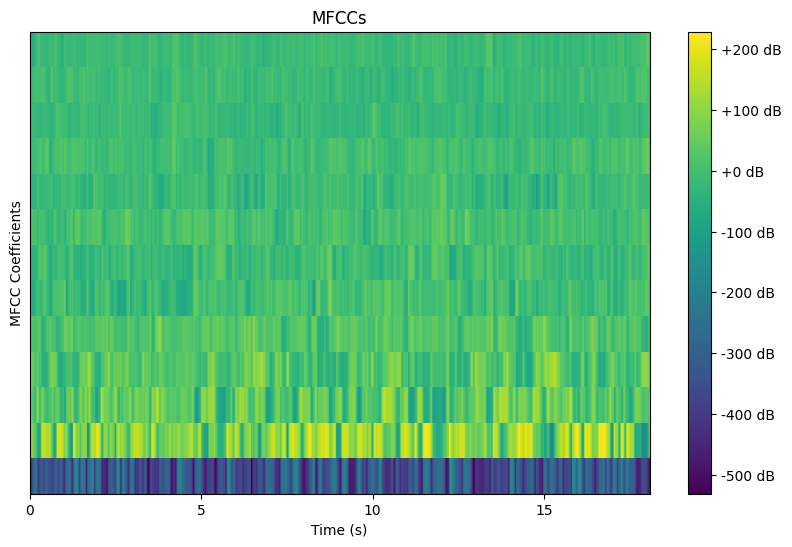

In [ ]:
n_mfcc = 13
mfccs = librosa.feature.mfcc(y=denoised_audio, sr=sr, n_mfcc=n_mfcc)

print(f"MFCCs shape: {mfccs.shape}")

plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

In [ ]:
n_mels = 128
n_fft = 2048
hop_length = 512

mel_spec = librosa.feature.melspectrogram(y=denoised_audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)

log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

print(f"Log-Mel Spectrogram shape: {log_mel_spec.shape}")
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bins')
plt.show()

Log-Mel Spectrogram shape: (128, 707)


In [ ]:
spectral_centroid = librosa.feature.spectral_centroid(y=denoised_audio, sr=sr, n_fft=2048, hop_length=512)

print(f"Spectral Centroid shape: {spectral_centroid.shape}")
plt.figure(figsize=(12, 4))
frames = range(spectral_centroid.shape[1])
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)

plt.plot(times, spectral_centroid.T, label="Spectral Centroid", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral Centroid Over Time")
plt.legend()
plt.show()

Spectral Centroid shape: (1, 707)


In [ ]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=denoised_audio, sr=sr, n_fft=2048, hop_length=512)

print(f"Spectral Bandwidth shape: {spectral_bandwidth.shape}")
plt.figure(figsize=(12, 4))
frames = range(spectral_bandwidth.shape[1])
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)

plt.plot(times, spectral_bandwidth.T, label="Spectral Bandwidth", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Frequency Spread (Hz)")
plt.title("Spectral Bandwidth Over Time")
plt.legend()
plt.show()

Spectral Bandwidth shape: (1, 707)


In [ ]:
n_bands = 6
spectral_contrast = librosa.feature.spectral_contrast(y=denoised_audio, sr=sr, n_fft=2048, hop_length=512, fmin=200.0, n_bands=n_bands)

print(f"Spectral Contrast shape: {spectral_contrast.shape}")
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectral_contrast, x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(label="Spectral Contrast (dB)")
plt.title("Spectral Contrast Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency Bands")
plt.show()


Spectral Contrast shape: (7, 707)


In [ ]:
zcr = librosa.feature.zero_crossing_rate(denoised_audio, frame_length=2048, hop_length=512)

print(f"Zero-Crossing Rate shape: {zcr.shape}")
plt.figure(figsize=(12, 4))
frames = range(zcr.shape[1])
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)
plt.plot(times, zcr.T, label="Zero-Crossing Rate", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("ZCR")
plt.title("Zero-Crossing Rate Over Time")
plt.legend()
plt.show()


Zero-Crossing Rate shape: (1, 707)


Energy shape: (702,)


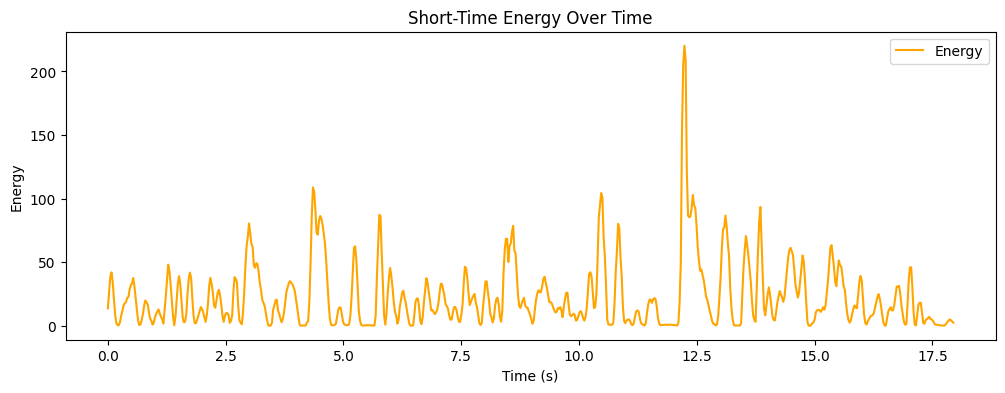

In [ ]:
frame_length = 2048
hop_length = 512

energy = np.array([
    np.sum(np.abs(denoised_audio[i:i + frame_length])**2)
    for i in range(0, len(denoised_audio) - frame_length, hop_length)
])

print(f"Energy shape: {energy.shape}")
plt.figure(figsize=(12, 4))
times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)

plt.plot(times, energy, label="Energy", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.title("Short-Time Energy Over Time")
plt.legend()
plt.show()


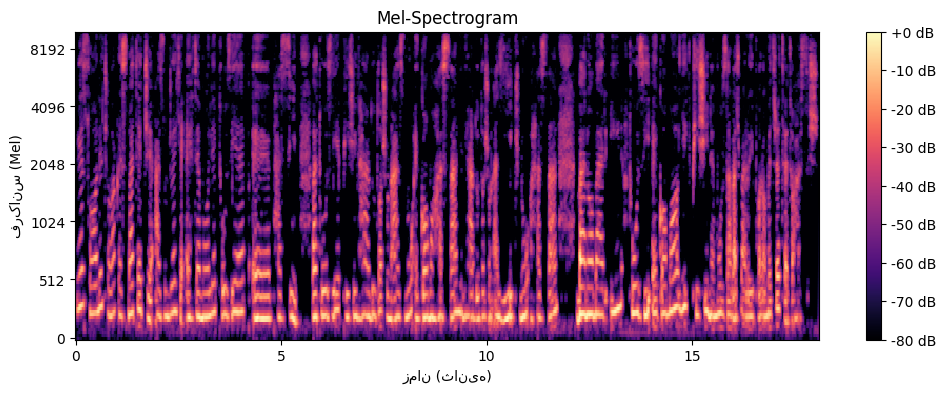

In [ ]:
n_mels = 128
mel_spectrogram = librosa.feature.melspectrogram(y=denoised_audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram")
plt.xlabel("زمان (ثانیه)")
plt.ylabel("فرکانس (Mel)")
plt.show()

In [28]:
audio_folder = "/content/drive/My Drive/HW1_M/"
audio_files = glob.glob(os.path.join(audio_folder, "*.mp3"))
def resample(audio , sr):
    target_sr = 20000
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    non_silent_intervals = librosa.effects.split(audio, top_db=30)

    non_silent_audio = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
    return non_silent_audio, sr

# List to store extracted features
features = []
print(len(audio_files))
n = 50

822


In [ ]:
for it in range(n):
    # Load audio file
    audio, sr = librosa.load(audio_files[it], sr=None)
    audio , sr = resample(audio, sr)
    audio = spectral_subtraction(audio , sr)
    audio = audio / np.max(np.abs(audio))
    audio, _ = librosa.effects.trim(audio, top_db=20)
    # Extract Features
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1)  # MFCC (13 values)
    log_mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128), axis=1)  # Log Mel-Spectrogram (128 values)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1)  # Spectral Centroid (1 value)
    spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1)  # Spectral Bandwidth (1 value)
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr), axis=1)  # Spectral Contrast (7 values)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio), axis=1)  # Zero-Crossing Rate (1 value)
    energy = np.mean(np.square(audio))  # Energy (1 value)

    # Concatenate all features into a single feature vector
    feature_vector = np.hstack([mfcc, log_mel, spec_centroid, spec_bandwidth, spec_contrast, zcr, energy])

    # Append to feature list
    features.append(feature_vector)

# Convert feature list to numpy array
features = np.array(features)
print(f"Feature Matrix Shape: {features.shape}")

In [25]:
pca_2d = PCA(n_components=2)
features_2d = pca_2d.fit_transform(features)

# Plot PCA 2D
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.7, color="blue")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - 2D Projection of Audio Features")
plt.show()


pca_3d = PCA(n_components=3)
features_3d = pca_3d.fit_transform(features)

# Plot PCA 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], alpha=0.7, color="red")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("PCA - 3D Projection of Audio Features")
plt.show()

In [26]:
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42)
features_tsne_2d = tsne_2d.fit_transform(features)

# Plot t-SNE 2D
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne_2d[:, 0], features_tsne_2d[:, 1], alpha=0.7, color="green")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE - 2D Projection of Audio Features")
plt.show()

AttributeError: 'list' object has no attribute 'shape'